In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
class GrayForecast():
#初始化
    def __init__(self, data, datacolumn=None):
        if isinstance(data, pd.core.frame.DataFrame):
            self.data=data
            try:
                self.data.columns = ['数据']
            except:
                if not datacolumn:
                    raise Exception('您传入的dataframe不止一列')
                else:
                    self.data = pd.DataFrame(data[datacolumn])
                    self.data.columns=['数据']
        elif isinstance(data, pd.core.series.Series):
            self.data = pd.DataFrame(data, columns=['数据'])
        else:
            self.data = pd.DataFrame(data, columns=['数据'])

        self.forecast_list = self.data.copy()

        if datacolumn:
            self.datacolumn = datacolumn
        else:
            self.datacolumn = None
        #save arg:
        #        data                DataFrame    数据
        #        forecast_list       DataFrame    预测序列
        #        datacolumn          string       数据的含义

#级比校验
    def level_check(self):
        # 数据级比校验
        n = len(self.data)
        lambda_k = np.zeros(n-1)
        for i in range(n-1):
            lambda_k[i] = self.data.ix[i]["数据"]/self.data.ix[i+1]["数据"]
            if lambda_k[i] < np.exp(-2/(n+1)) or lambda_k[i] > np.exp(2/(n+2)):
                flag = False
        else:
            flag = True

        self.lambda_k = lambda_k

        if not flag:
            print("级比校验失败，请对X(0)做平移变换")
            return False
        else:
            print("级比校验成功，请继续")
            return True
    #save arg:
    #        lambda_k            1-d list
    
#GM(1,1)建模
    def GM_11_build_model(self, forecast=5):
        if forecast > len(self.data):
            raise Exception('您的数据行不够')
        X_0 = np.array(self.forecast_list['数据'].tail(forecast))
    #       1-AGO
        X_1 = np.zeros(X_0.shape)
        for i in range(X_0.shape[0]):
            X_1[i] = np.sum(X_0[0:i+1])
    #       紧邻均值生成序列
        Z_1 = np.zeros(X_1.shape[0]-1)
        for i in range(1, X_1.shape[0]):
            Z_1[i-1] = -0.5*(X_1[i]+X_1[i-1])

        B = np.append(np.array(np.mat(Z_1).T), np.ones(Z_1.shape).reshape((Z_1.shape[0], 1)), axis=1)
        Yn = X_0[1:].reshape((X_0[1:].shape[0], 1))

        B = np.mat(B)
        Yn = np.mat(Yn)
        a_ = (B.T*B)**-1 * B.T * Yn

        a, b = np.array(a_.T)[0]

        X_ = np.zeros(X_0.shape[0])
        def f(k):
            return (X_0[0]-b/a)*(1-np.exp(a))*np.exp(-a*(k))

        self.forecast_list.loc[len(self.forecast_list)] = f(X_.shape[0])
        print(f(X_.shape[0]))
#预测
    def forecast(self, time=5, forecast_data_len=5):
        for i in range(time):
            self.GM_11_build_model(forecast=forecast_data_len)
#打印日志
    def log(self):
        res = self.forecast_list.copy()
        if self.datacolumn:
            res.columns = [self.datacolumn]
        return res
#重置
    def reset(self):
        self.forecast_list = self.data.copy()
#作图
    def plot(self):
        self.forecast_list.plot()
        if self.datacolumn:
            plt.ylabel(self.datacolumn)
            plt.legend([self.datacolumn])
        plt.show()

In [5]:
df1 = pd.read_excel("C:/Users/Forry/Desktop/q1.xlsx",sheet_name='Sheet1')
print(df1)

     0   1
0   20  25
1   20  28
2   38  30
3   40  21
4   25  18
5   24  25
6   19  25
7   27  20
8   16  33
9   44  28
10  28  28
11  32  28
12  21  24
13  47  40
14  32  31
15  42  26
16  26  42
17  31  33
18  47  51


57.54933888484373
65.50568729382717
81.72578913761666
93.67066424131707
111.1575196092294
131.47456514214943
153.39993778918068
180.58535610357663
211.24341557649987
246.75148182004125
             1
0    25.000000
1    28.000000
2    30.000000
3    21.000000
4    18.000000
5    25.000000
6    25.000000
7    20.000000
8    33.000000
9    28.000000
10   28.000000
11   28.000000
12   24.000000
13   40.000000
14   31.000000
15   26.000000
16   42.000000
17   33.000000
18   51.000000
19   57.549339
20   65.505687
21   81.725789
22   93.670664
23  111.157520
24  131.474565
25  153.399938
26  180.585356
27  211.243416
28  246.751482


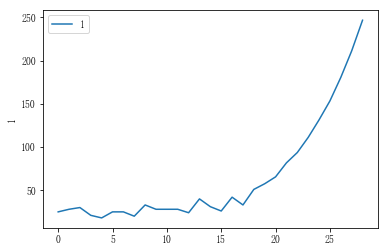

In [8]:
#交通事故预测
gf = GrayForecast(df1, 1)
gf.forecast(10)
#print(gf)
print(gf.log())
gf.plot()

196.06591159224294
193.21853391787974
210.1497499504743
228.19412375438807
237.35792571508398
257.0767079745656
273.079091478851
290.06645968375494
310.608986037577
329.96126571166803
         火灾（起）
0    87.000000
1    97.000000
2   170.000000
3   166.000000
4   161.000000
5   196.065912
6   193.218534
7   210.149750
8   228.194124
9   237.357926
10  257.076708
11  273.079091
12  290.066460
13  310.608986
14  329.961266


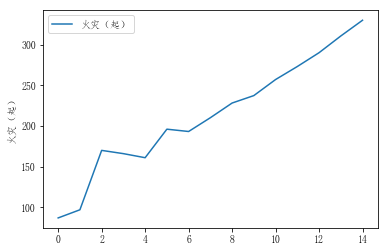

In [15]:
#火灾预测
gf2 = GrayForecast(df2, '火灾（起）')
gf2.forecast(10)
#print(gf)
print(gf2.log())
gf2.plot()